# Discrete hedging experiment for a European Call option under the Heston model

> TODO: Add a description to the experiment

> Under the Heston but we are using the Black-Scholes delta for hedging

In [7]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [18]:
import numpy as np

from jax import vmap
import jax.numpy as jnp
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','no-latex'])

from jaxfin.models.heston import UnivHestonModel
from jaxfin.price_engine.black_scholes import european_price, delta_european

from src.heston.fourier import fourier_inv_call_1, delta_call

In [9]:
seed = 42

$$
S(0) = 100 \\
\sigma = 0.2 \\
\mu = 0.00 \\
$$

Let set $N = 252$, which means that we are rebalancing our portfolio daily.

In [10]:
# Initialize the Univariate Heston Model
s0 = 100.0
v0 = 0.2
mean = 0.0
kappa = 2.0
theta = 0.3
sigma = 0.3
rho = -0.6

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)

In [11]:
maturity = 1.0
N = 252
dt = maturity / N
n_sim = 1000

stock_paths = heston_model.sample_paths(seed, maturity, N, n_sim)

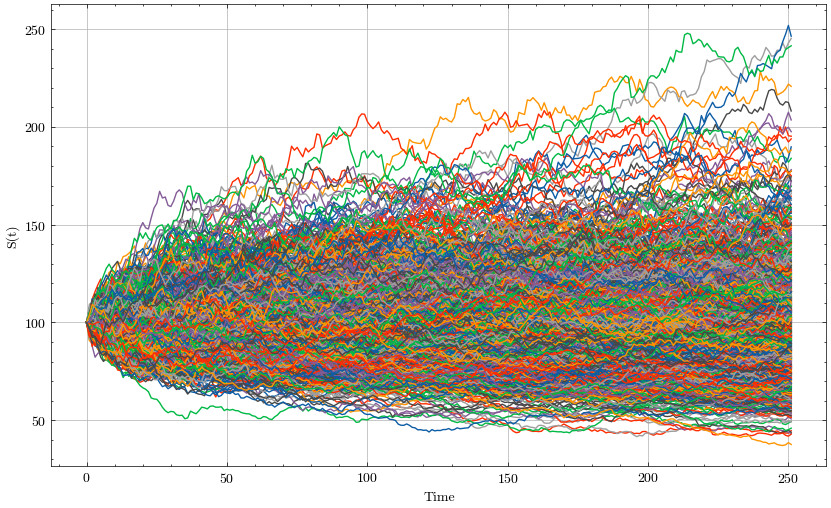

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(stock_paths)
plt.ylabel('S(t)')
plt.xlabel('Time')
plt.grid()
plt.show()

In [13]:
K = 110
discount_rate = 0.0
dividends = 0.0
bs_vol = theta

## Hedging experiment with Black scholes $\Delta$

In [14]:
v_delta_european = vmap(delta_european, in_axes=(0, None, None, None, None))

In [15]:
deltas = [v_delta_european(stock_paths[i], K, maturity - i * dt, bs_vol, discount_rate) for i in range(0, N)]
cs = [european_price(stock_paths[i], K, maturity - i * dt, bs_vol, discount_rate, dtype=jnp.float32) for i in range(0, N)]
b = [cs[0] - deltas[0] * stock_paths[0]]
vs = [cs[0]]

for i in range(1, N):
    vs.append(deltas[i - 1] * stock_paths[i] + b[i - 1])
    b.append(vs[i] - deltas[i] * stock_paths[i])
    
hedge_error = jnp.asarray(vs) - jnp.maximum(stock_paths - K, 0)

In [16]:
print(f'The mean hedge error is: {jnp.mean(hedge_error[-1])}')
print(f'The (normalized) standard deviation is: {jnp.std(hedge_error[-1]) / jnp.asarray(cs)[0, 0]}')

The mean hedge error is: 1.1143580675125122
The (normalized) standard deviation is: 0.15191544592380524


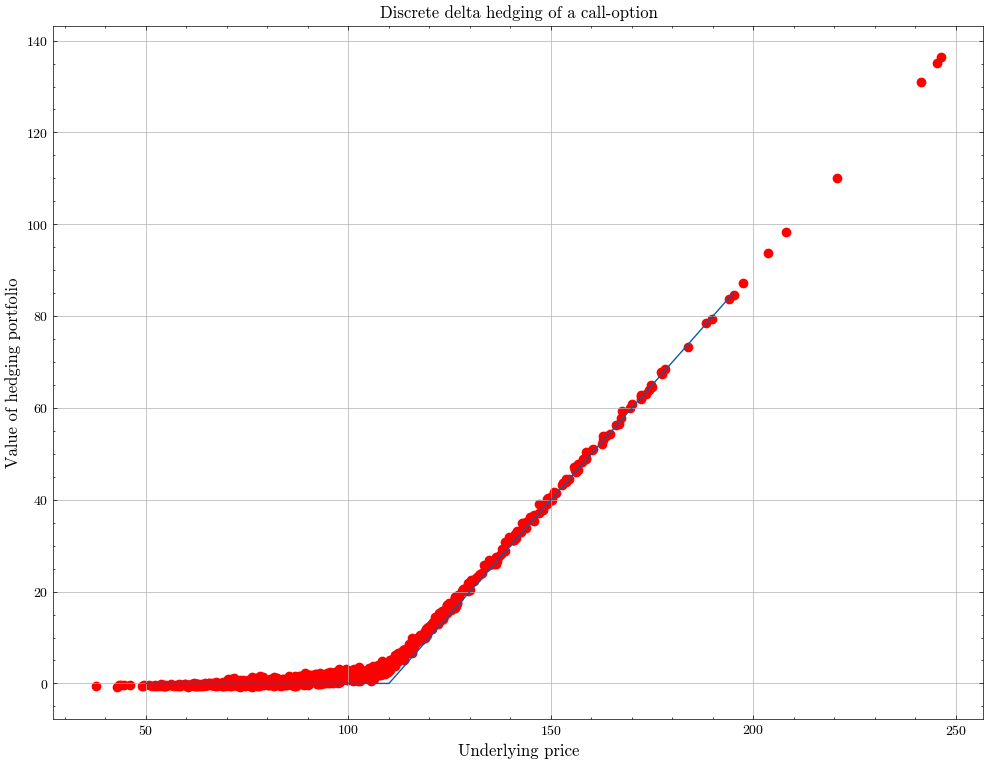

In [17]:
font = {'color':  'black',
        'weight': 'normal',
        'size': 12
       }

s = jnp.arange(50,200,5)
payoff= jnp.maximum(s - K, 0)
plt.figure(figsize=(12,9))
plt.plot(s,payoff)
plt.scatter(stock_paths[-1, :], jnp.asarray(vs)[-1, :], c='red')
plt.title("Discrete delta hedging of a call-option", fontdict=font)
plt.xlabel("Underlying price", fontdict=font)
plt.ylabel("Value of hedging portfolio", fontdict=font)
plt.grid(True)
plt.show()

## Hedging experiment with Fourier Transform and Delta

In [19]:
v_fourier_inv_call_1 = vmap(fourier_inv_call_1, in_axes=(0, None, None, None, None, None, None, None, None))
v_fourier_delta_call = vmap(delta_call, in_axes=(0, None, None, None, None, None, None, None, None))

In [21]:
deltas = [v_fourier_delta_call(stock_paths[i], K, maturity - i * dt, v0, mean, theta, sigma, kappa, rho) for i in range(0, N)]
cs = [v_fourier_inv_call_1(stock_paths[i], K, maturity - i * dt, v0, mean, theta, sigma, kappa, rho) for i in range(0, N)]
b = [cs[0] - deltas[0] * stock_paths[0]]
vs = [cs[0]]

for i in range(1, N):
    vs.append(deltas[i - 1] * stock_paths[i] + b[i - 1])
    b.append(vs[i] - deltas[i] * stock_paths[i])
    
hedge_error = jnp.asarray(vs) - jnp.maximum(stock_paths - K, 0)

In [25]:
jnp.mean(jnp.asarray(vs) - jnp.asarray(cs))

Array(3.8300557, dtype=float32)

In [26]:
jnp.std(jnp.asarray(vs) - jnp.asarray(cs)) / jnp.asarray(cs)[0, 0]

Array(0.19192551, dtype=float32)

In [22]:
print(f'The mean hedge error is: {jnp.mean(hedge_error[-1])}')
print(f'The (normalized) standard deviation is: {jnp.std(hedge_error[-1]) / jnp.asarray(cs)[0, 0]}')

The mean hedge error is: 8.869969367980957
The (normalized) standard deviation is: 0.2378145456314087


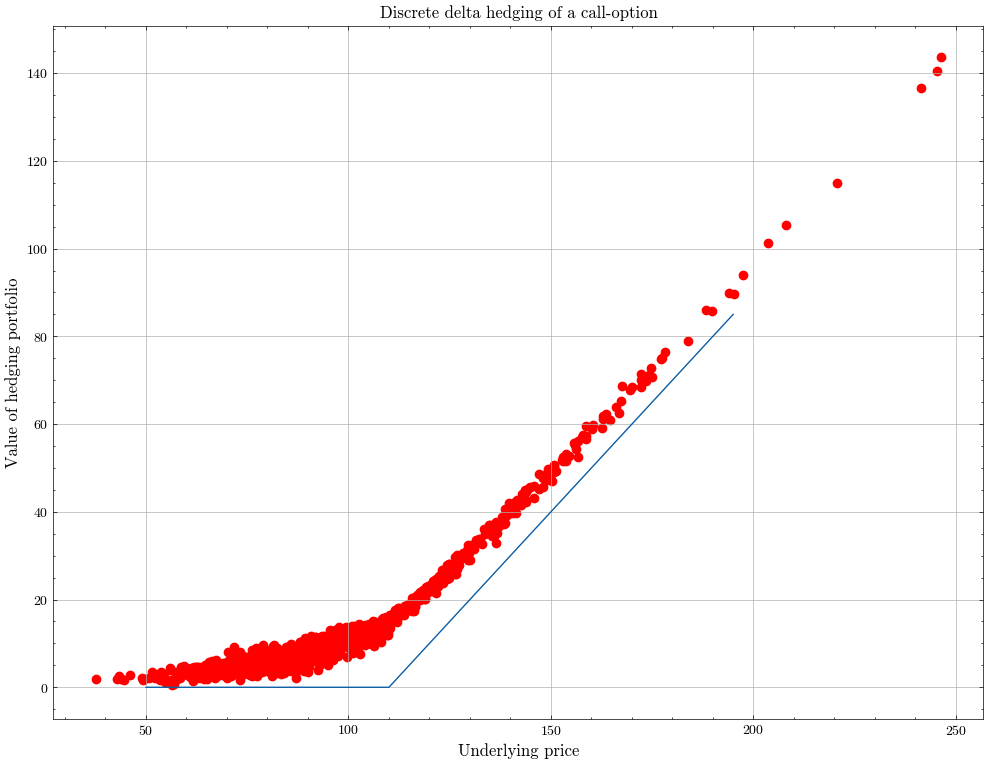

In [23]:
font = {'color':  'black',
        'weight': 'normal',
        'size': 12
       }

s = jnp.arange(50,200,5)
payoff= jnp.maximum(s - K, 0)
plt.figure(figsize=(12,9))
plt.plot(s,payoff)
plt.scatter(stock_paths[-1, :], jnp.asarray(vs)[-1, :], c='red')
plt.title("Discrete delta hedging of a call-option", fontdict=font)
plt.xlabel("Underlying price", fontdict=font)
plt.ylabel("Value of hedging portfolio", fontdict=font)
plt.grid(True)
plt.show()